# sWeights extended and COWs

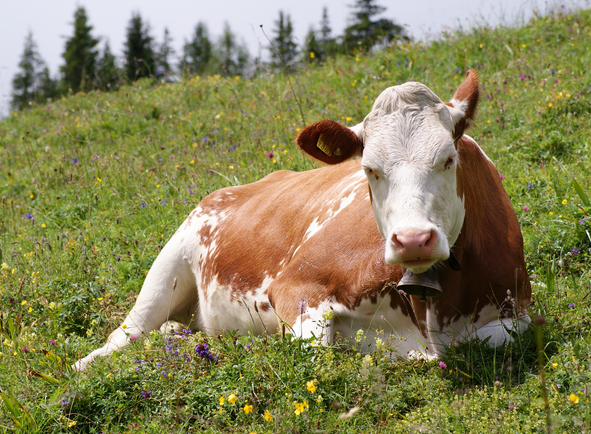

## sWeights are really orthonormal functions

The sWeights (or sPlot) method allows one to calculate an empirical estimate of the signal density of a control variable using a fit of a mixed signal and background model to a discriminating variable. It is quite powefull especially when you do not have a good gauge on what a source(/s) should look like for the control variable. If you did have this one could of course simply do a higher-dimensional fit. 

We start with a data density model in the variable used to discriminant -> Mass ($m$) and the variable you want to infer the shape of the control variable -> Lifetime ($t$)

- There are two sources; a signal and background, and we can define the density like this:

$$
f(m, t)=N_s g_s(m) h(t)+N_b g_b(m) h(t)=N (z g_s(m) h(t)+(1-z) g_b(m) h(t)) 
$$

- known: We can find good estimates on the signal pdf $g_s(m)$ and background pdf $g_b(m)$ through a Maximum Likelihood fit. Can also find the yields of each source $N_s = N * z$ and $N_b = N * (1-z)$ through performing an extended maximum likelihood fit or fractions themselves through a normal maximum likelihood fit. 

- wanted:signal PDF $s(t)$ and background PDF $b(t)$

Note:
- Any other two variables can be used, as long as they are independent in each source.

#### The procedure:

We postulate a weight function, $w_s(m)$, exists which extracts the signal component, $z h_s(t)$ (where $z = N_s / N$):

$$
\begin{aligned}
z h_s(t) & = \int \mathrm{d} m w_s(m) f(m, t) \\
& =\int \mathrm{d} m w_s(m)\left[z g_s(m) h_s(t)+(1-z) g_b(m) h_b(t)\right] \\
& =z h_s(t) \int \mathrm{d} m w_s(m) g_s(m)+(1-z) h_b(t) \int \mathrm{d} m w_s(m) g_b(m)
\end{aligned}
$$

The left and right side of the equation are only equal if the following conditions hold:

$$
\int \mathrm{d} m w_s(m) g_s(m)=1 \text { and } \int \mathrm{d} m w_s(m) g_b(m)=0 .
$$

Hence, $w_s$ and $g_s$ are normal and $w_s$ and $g_b$ are orthogonal.

There are infinitely many orthonormal functions, $w_s$, which can be chosen, a simple example is a piece-wise constant function -> This is known as the classic sideband subtraction method.


Can chose a function $w_s$ which minimises the variance of the weights themselves:


$$
w_s(m)=\frac{A_{s s} g_s(m)+A_{s b} g_b(m)}{z g_s(m)+ (1-z) g_b(m)} .
$$

where
$$
\begin{aligned}
&\underbrace{\left(\begin{array}{ll}
W_{s s} & W_{s b} \\
W_{s b} & W_{b b}
\end{array}\right)}_{\boldsymbol{W}} \cdot \underbrace{\left(\begin{array}{ll}
A_{s s} & A_{s b} \\
A_{s b} & A_{b b}
\end{array}\right)}_{\boldsymbol{A}}=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right),\\
&\text { with }\\
&W_{c d}=\int \mathrm{d} m \frac{g_c(m) g_d(m)}{z g_s(m)+(1-z) g_b(m)},
\end{aligned}
$$

I will now refer to values with  "^"  as sample estimates taken from maximum likelihood fits.

From this there are variants of the sWeights method that can be used:


- Variant A: Actually compute the matrix elements analytically or numerically:

$$
\widehat{W}_{c d}^A=\int \mathrm{d} m \frac{\hat{g}_c(m) \hat{g}_d(m)}{\hat{z} \hat{g}_s(m)+(1-\hat{z}) \hat{g}_b(m)}
$$

- Variant B: In a finite sample, the arithmetic mean is an unbiased estimate of the expectation due to the law of large numbers.
e.g. For any function $\phi(m)$ the integral can be written as an expectation value over the pdf $g_{m}$:

$$
\int \mathrm{d} m \phi(m)=\int \mathrm{d} m g(m) \frac{\phi(m)}{g(m)}=\mathrm{E}\left[\frac{\phi(m)}{g(m)}\right] .
$$

Can apply this to the above to compute the matrix elements through the arithmetic mean:

$$
\widehat{W}_{c d}^B=\frac{1}{N} \sum_i \frac{\hat{g}_c\left(m_i\right) \hat{g}_d\left(m_i\right)}{\left(\hat{z} \hat{g}_s\left(m_i\right)+(1-\hat{z}) \hat{g}_b\left(m_i\right)\right)^2},
$$

This is method relatively everyone uses for sWeights normally so I will refer to them as classic sWeights

- Variant C: When performing an extended maximum likelihood fit, the elements of the Hessian matrix "happen" to nicely resemble the form of the matrix $\widehat{W}_{c d}^B$ in Variant B:

$$
\begin{aligned}
-\left.\frac{\partial^2 \ln \mathcal{L}}{\partial N_c \partial N_d}\right|_{N_s=N \hat{z}, N_b=N(1-\hat{z})} & =\sum_i \frac{\hat{g}_c\left(m_i\right) \hat{g}_d\left(m_i\right)}{\left(N \hat{z} \hat{g}_s\left(m_i\right)+N(1-\hat{z}) \hat{g}_b\left(m_i\right)\right)^2} \\
& =\frac{1}{N} \widehat{W}_{c d}^B .
\end{aligned}
$$

so you could:

- (i) Get the covariance matrix, then isolate the yield part and correct by multiplying by N. 

or

- (ii) Perform another fit with the shape parameters fixed, leaving only the yield parameters floating.

This seems the same as Variant B, though you must remember how the Hessian is calculated, not analytically but instead computed numerically. This is why it is defined as a seperate variant.

In [1]:
from types import SimpleNamespace

# external requirements
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# from this package
from sweights import SWeight # for classic sweights
from sweights import Cow     # for custom orthogonal weight functions
from sweights import cov_correct, approx_cov_correct # for covariance corrections
from sweights.testing import make_classic_toy # to generate a toy dataset
from sweights.util import plot_binned, make_weighted_negative_log_likelihood

### Make pdfs, plot ground truth and toy data

In [2]:
# make a toy model
true_yield = SimpleNamespace()
true_yield.s = 1000
true_yield.b = 1000

# mass
mrange = (0, 1)
m_truth = SimpleNamespace()
m_truth.mu = 0.5
m_truth.sigma = 0.1
m_truth.slope = 1

# time
trange = (0, 1.5)
t_truth = SimpleNamespace()
t_truth.slope = 0.2
t_truth.mu = 0.1
t_truth.sigma = 1.0

toy = make_classic_toy(
    1,
    s=true_yield.s,
    b=true_yield.b,
    mrange=mrange,
    trange=trange,
    ms_mu=m_truth.mu,
    ms_sigma=m_truth.sigma,
    mb_mu=m_truth.slope,
    ts_mu=t_truth.slope,
    tb_mu=t_truth.mu,
    tb_sigma=t_truth.sigma,
)

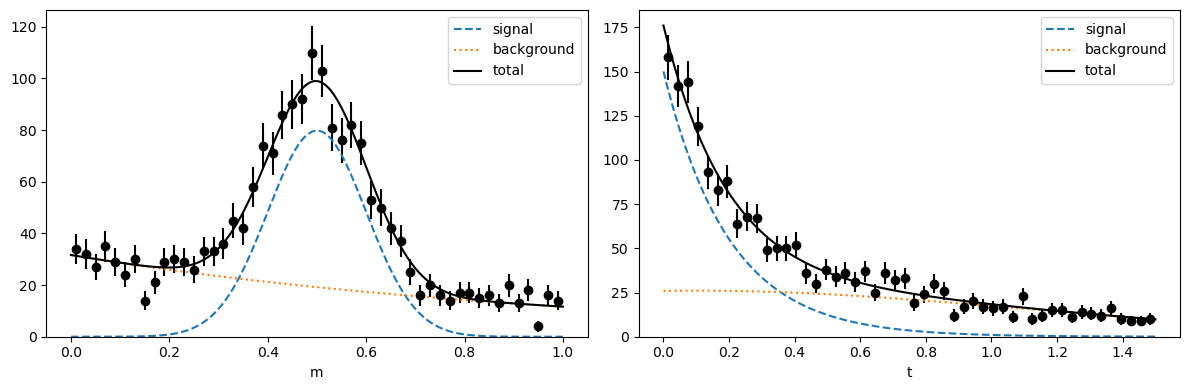

In [3]:
# m-density for fitting and plotting (not normalized)
def m_density(x, s, b, mu, sigma, slope):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))

    db = expon(mrange[0], slope)
    bnorm = np.diff(db.cdf(mrange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


# t-density for fitting and plotting (not normalized)
def t_density(x, s, b, slope, mu, sigma):

    ds = expon(trange[0], slope)
    snorm = np.diff(ds.cdf(trange))

    db = norm(mu, sigma)
    bnorm = np.diff(db.cdf(trange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


def plot(toy, bins=50, npoint=400, draw_pdf=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(ax[0])
    plot_binned(toy[0], bins=bins, range=mrange, color="k")
    plt.sca(ax[1])
    plot_binned(toy[1], bins=bins, range=trange, color="k")

    if draw_pdf:
        m = np.linspace(*mrange, npoint)
        mnorm = (mrange[1] - mrange[0]) / bins

        par = m_truth.mu, m_truth.sigma, m_truth.slope
        s = m_density(m, true_yield.s, 0, *par)
        b = m_density(m, 0, true_yield.b, *par)
        p = s + b

        ax[0].plot(m, mnorm * s, "C0--", label="signal")
        ax[0].plot(m, mnorm * b, "C1:", label="background")
        ax[0].plot(m, mnorm * p, "k-", label="total")

        t = np.linspace(*trange, npoint)
        tnorm = (trange[1] - trange[0]) / bins

        par = t_truth.slope, t_truth.mu, t_truth.sigma
        s = t_density(t, true_yield.s, 0, *par)
        b = t_density(t, 0, true_yield.b, *par)
        p = s + b

        ax[1].plot(t, tnorm * s, "C0--", label="signal")
        ax[1].plot(t, tnorm * b, "C1:", label="background")
        ax[1].plot(t, tnorm * p, "k-", label="total")

    ax[0].set_xlabel("m")
    ax[0].set_ylim(bottom=0)
    ax[0].legend()

    ax[1].set_xlabel("t")
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    fig.tight_layout()


plot(toy)

What we see when we get the data:

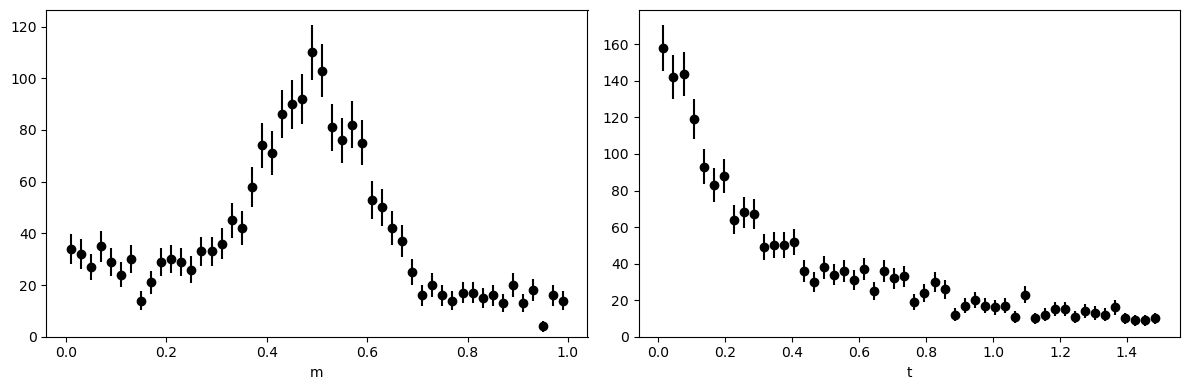

In [4]:
def plot(toy, bins=50, npoint=400, draw_pdf=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(ax[0])
    plot_binned(toy[0], bins=bins, range=mrange, color="k")
    plt.sca(ax[1])
    plot_binned(toy[1], bins=bins, range=trange, color="k")

    if draw_pdf:
        m = np.linspace(*mrange, npoint)
        mnorm = (mrange[1] - mrange[0]) / bins

        par = m_truth.mu, m_truth.sigma, m_truth.slope
        s = m_density(m, true_yield.s, 0, *par)
        b = m_density(m, 0, true_yield.b, *par)
        p = s + b

        # ax[0].plot(m, mnorm * s, "C0--", label="signal")
        # ax[0].plot(m, mnorm * b, "C1:", label="background")
        # ax[0].plot(m, mnorm * p, "k-", label="total")

        t = np.linspace(*trange, npoint)
        tnorm = (trange[1] - trange[0]) / bins

        par = t_truth.slope, t_truth.mu, t_truth.sigma
        s = t_density(t, true_yield.s, 0, *par)
        b = t_density(t, 0, true_yield.b, *par)
        p = s + b

        # ax[1].plot(t, tnorm * s, "C0--", label="signal")
        # ax[1].plot(t, tnorm * b, "C1:", label="background")
        # ax[1].plot(t, tnorm * p, "k-", label="total")

    ax[0].set_xlabel("m")
    ax[0].set_ylim(bottom=0)
    # ax[0].legend()

    ax[1].set_xlabel("t")
    ax[1].set_ylim(bottom=0)
    # ax[1].legend()

    fig.tight_layout()

plot(toy)

### Fit toy data in the m-variable

In [5]:
# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(x, s, b, mu, sigma, slope):
    return (s + b, m_density(x, s, b, mu, sigma, slope))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=true_yield.s,
    b=true_yield.b,
    mu=m_truth.mu,
    sigma=m_truth.sigma,
    slope=m_truth.slope,
)
mi.limits["s", "b"] = (0, true_yield.s + true_yield.b)
mi.limits["mu"] = mrange
mi.limits["sigma"] = (0, mrange[1] - mrange[0])
mi.limits["slope"] = (0, 50)

mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.696e+04                 │              Nfcn = 142              │
│ EDM = 1.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    960    │    50     │            │            │    0    │  2000   │       │
│ 1 │ b     │  1.02e3   │  0.05e3   │            │            │    0    │  2000   │       │
│ 2 │ mu    │   0.494   │   0.005   │            │            │    0    │    1    │       │
│ 3 │ sigma │   0.097   │   0.004   │            │            │    0    │    1    │       │
│ 4 │ slope │   1.14    │   0.16    │            │            │    0    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │   2.13e+03     -1.2e3 -12.228e-3  91.430e-3     -1.037 │
│     b │     -1.2e3   2.18e+03  12.225e-3 -91.418e-3      1.037 │
│    mu │ -12.228e-3  12.225e-3   2.06e-05  -0.002e-3  -0.155e-3 │
│ sigma │  91.430e-3 -91.418e-3  -0.002e-3   1.87e-05  -0.070e-3 │
│ slope │     -1.037      1.037  -0.155e-3  -0.070e-3     0.0244 │
└───────┴────────────────────────────────────────────────────────┘

In [6]:
mi.covariance

,s,b,mu,sigma,slope
s,2.13e+03,-1.2e3 (-0.540),-12.228e-3 (-0.058),91.430e-3 (0.458),-1.037 (-0.144)
b,-1.2e3 (-0.540),2.18e+03,12.225e-3 (0.058),-91.418e-3 (-0.453),1.037 (0.142)
mu,-12.228e-3 (-0.058),12.225e-3 (0.058),2.06e-05,-0.002e-3 (-0.086),-0.155e-3 (-0.219)
sigma,91.430e-3 (0.458),-91.418e-3 (-0.453),-0.002e-3 (-0.086),1.87e-05,-0.070e-3 (-0.104)
slope,-1.037 (-0.144),1.037 (0.142),-0.155e-3 (-0.219),-0.070e-3 (-0.104),0.0244


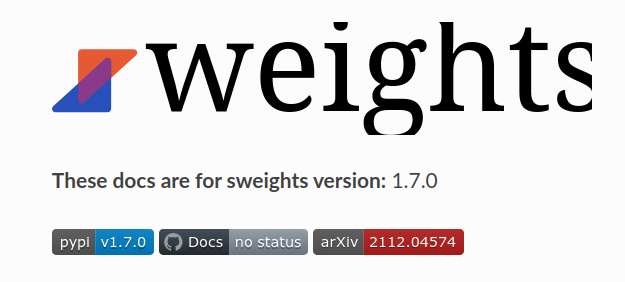

In [7]:
def spdf(m):
    return m_density(m, 1, 0, *mi.values[2:])


def bpdf(m):
    return m_density(m, 0, 1, *mi.values[2:])

print("Variant A: integration method")
sweight_variant_a = SWeight(
							toy[0],
							[spdf, bpdf],
							[mi.values["s"], mi.values["b"]],
							[mrange],
							method="integration",
							compnames=("sig", "bkg"),
							verbose=True,
							checks=True,
						)

print("Variant B: summation method")
sweight_variant_b = SWeight(
							toy[0],
							[spdf, bpdf],
							[mi.values["s"], mi.values["b"]],
							[mrange],
							method="summation",
							compnames=("sig", "bkg"),
							verbose=True,
							checks=True,
						)

print("Variant Ci: subhess method")
sweight_variant_ci = SWeight(
							toy[0],
							[spdf, bpdf],
							[mi.values["s"], mi.values["b"]],
							[mrange],
							method="subhess",
                            alphas=np.linalg.inv(np.linalg.inv(np.array(mi.covariance))[0:2, 0:2]),
							compnames=("sig", "bkg"),
							verbose=True,
							checks=True,
						)

mi_fixed = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=true_yield.s,
    b=true_yield.b,
    mu=mi.values['mu'],
    sigma=mi.values['sigma'],
    slope=mi.values['slope'],
)
mi_fixed.limits["s", "b"] = (0, true_yield.s + true_yield.b)
mi_fixed.fixed["mu", "sigma", "slope"] = True

mi_fixed.migrad()
mi_fixed.hesse()

print("Variant Cii: subhess method")
sweight_variant_cii = SWeight(
							toy[0],
							[spdf, bpdf],
							[mi.values["s"], mi.values["b"]],
							[mrange],
							method="subhess",
                            alphas=np.array(mi_fixed.covariance)[0:2, 0:2],
							compnames=("sig", "bkg"),
							verbose=True,
							checks=True,
						)

Variant A: integration method
Initialising sweight with the integration method:
    PDF normalisations:
	 0 1.0
	 1 1.0
    W-matrix:
	[[0.00072631 0.00029389]
	 [0.00029389 0.00070364]]
    A-matrix:
	[[1656.82652635 -691.99706829]
	 [-691.99706829 1710.19701272]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00000000e+00 -1.05366743e-10]
	 [-1.28832268e-10  1.00000000e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   964.9299 |   964.8295 |    -0.01% |
	  1        |  1018.0701 |  1018.1999 |     0.01% |
Variant B: summation method
Initialising sweight with the summation method:
    PDF normalisations:
	 0 1.0
	 1 1.0
    W-matrix:
	[[0.00072638 0.00029386]
	 [0.00029386 0.00070361]]
    A-matrix:
	[[1656.59790133 -691.86886984]
	 [-691.86886984 1710.19865477]]
    Integral of w*pdf matrix (should be close to the
         

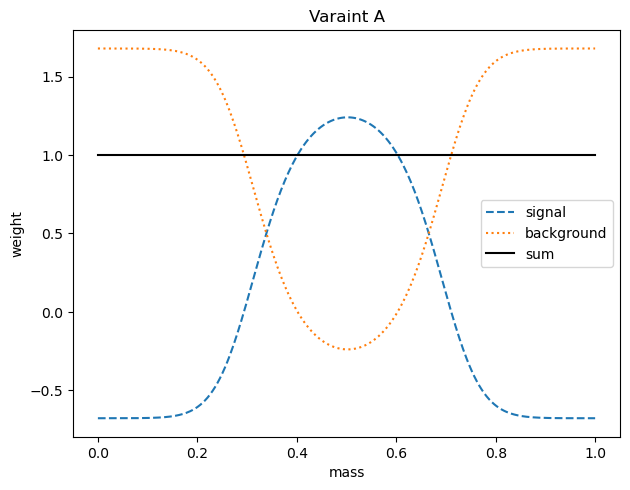

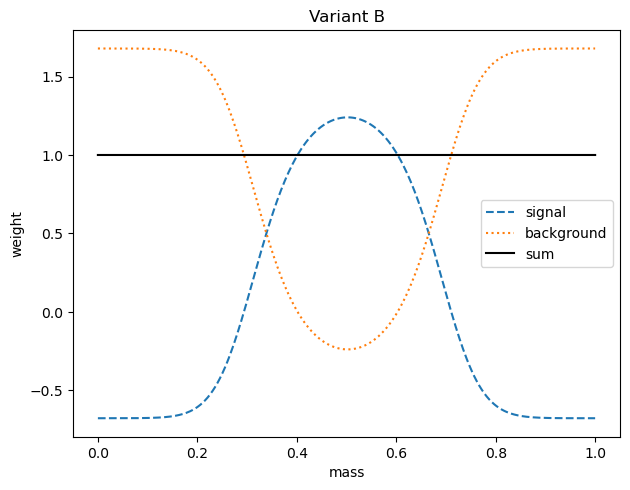

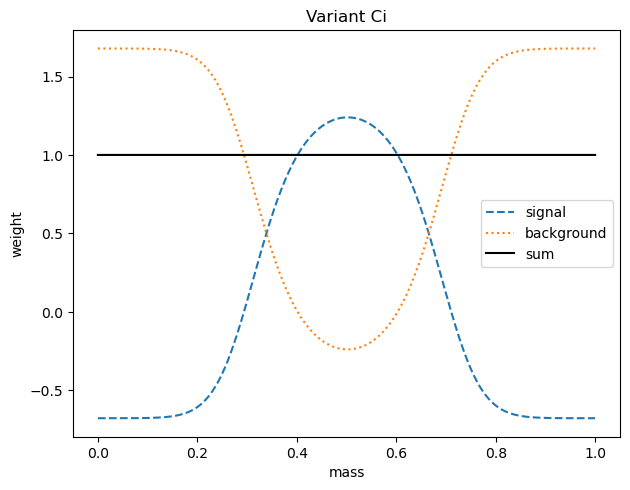

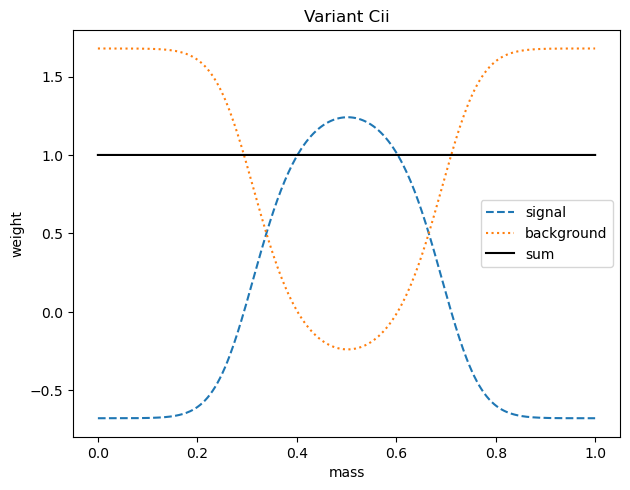

In [8]:
def plot_weights(x, sw, bw):
    plt.figure()
    plt.plot(x, sw, "C0--", label="signal")
    plt.plot(x, bw, "C1:", label="background")
    plt.plot(x, sw + bw, "k-", label="sum")
    plt.xlabel("mass")
    plt.ylabel("weight")
    plt.legend()
    plt.tight_layout()

for method, weighter in zip( ['Varaint A', 'Variant B', 'Variant Ci', 'Variant Cii'], [sweight_variant_a, sweight_variant_b, sweight_variant_ci, sweight_variant_cii] ):
    x = np.linspace(*mrange,400)
    swp = weighter.get_weight(0, x)
    bwp = weighter.get_weight(1, x)
    plot_weights(x, swp, bwp)
    plt.title(method)

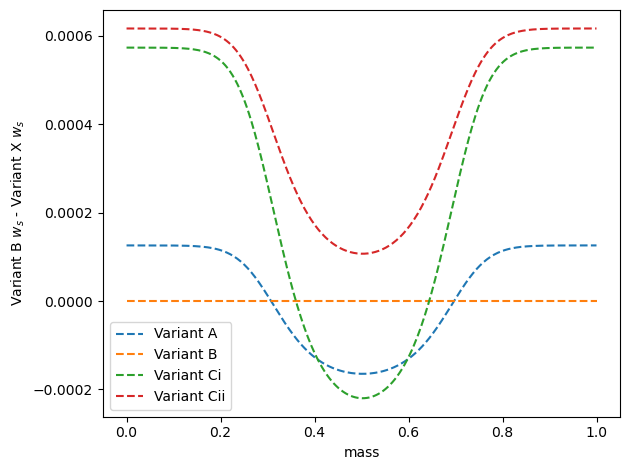

In [9]:

def plot_weight_differences():
	plt.figure()
	x = np.linspace(*mrange,400)
	plt.plot(x, sweight_variant_b.get_weight(0, x) - sweight_variant_a.get_weight(0, x), "--", label="Variant A")
	plt.plot(x, sweight_variant_b.get_weight(0, x) - sweight_variant_b.get_weight(0, x), "--", label="Variant B")
	plt.plot(x, sweight_variant_ci.get_weight(0, x) - sweight_variant_b.get_weight(0, x), "--", label="Variant Ci")
	plt.plot(x, sweight_variant_cii.get_weight(0, x) - sweight_variant_b.get_weight(0, x), "--", label="Variant Cii")
	plt.xlabel("mass")
	plt.ylabel(r"Variant B $w_{s}$ - Variant X $w_{s}$")
	plt.legend()
	plt.tight_layout()

plot_weight_differences()


### Variance of estimates from weighted data

So we have sWeights, but something less discussed is how to especially perform parameter estimation using the sweighted unbinned data sets, "how do we propogate the correct uncertainties of the parameters"?

Let's think we incorporate the sWeights in the maximum likihood condition what what we get is a weighted score function to solve:

$$
\sum_i w_i \frac{\partial \ln h_s\left(t_i ; \phi\right)}{\partial \phi_k} = 0
$$

From this we could try to derive the covariance matrix from the inverse of the Hessian matrix:

$$
-(\sum_i w_i \frac{\partial^{2} \ln h_s\left(t_i ; \phi\right)}{\partial \phi_k \partial \phi_j})^{-1}
$$

which will generally not give asymptotically correct confidence intervals. To see this assume our piece-wise weight function, there will be over-estimation (w>1) and under-estimation (w<1).

This is not actually a true likelihood score equation it is known as an M-estimator. The way to get an asymptotic covariance matrix is to use a "sandwich" estimator, "sandwich" as it has this form:  
$$
\underbrace{A^{-1}}_{\text {bread }} \underbrace{B}_{\text {meat }} \underbrace{A^{-T}}_{\text {bread }^{\top}}
$$

Our particular problem is known in the literature as a two-step M-estimation, as the sWeights rely on a W matrix determination which rely on a yield estimation. This is expanded on in [1] and [2]. The full asymptotic covariance matrix is huge, luckily the package will do it for us.

[1]: https://www.sciencedirect.com/science/article/pii/S0168900222006076?ref=pdf_download&fr=RR-2&rr=9a7a95fbba6d2b32 "Custom Orthogonal Weight functions (COWs) for event classification"
[2]: https://inspirehep.net/literature/1762842 "Parameter uncertainties in weighted unbinned maximum likelihood fits"

Especially [2] goes in depth of how we must correctly propogate these parameter uncertainties, and it provides us two valid ways:

- Bootstrapping the data (again using 1000 bootstraps) and rederiving the sWeights for every bootstrapped sample,

or
 
- The method above for determining the full asymptotic covariance matrix, which includes the efect of nuisance parameters in the sWeight determination.

In [10]:
# signal pdf in t-domain
def t_signal_pdf(x, slope):
    return t_density(x, 1, 0, slope, 0, 1)


fitted_slopes = []
for method, weighter in (("Variant A", sweight_variant_a), ("Variant B", sweight_variant_b), ("Variant Ci", sweight_variant_ci), ("Variant Cii", sweight_variant_cii)):
    # get signal weights
    w = weighter(toy[0])

    # do the minimisation
    tmi = Minuit(
        make_weighted_negative_log_likelihood(toy[1], w, t_signal_pdf),
        slope=t_truth.slope,
    )
    tmi.limits["slope"] = (0, 10)
    tmi.migrad()
    tmi.hesse()

    # do the correction
    fitted_slopes.append(tmi.values["slope"])

    # first order correction
    ncov = approx_cov_correct(
        t_signal_pdf, toy[1], w, tmi.values, tmi.covariance, verbose=False
    )

    # second order correction
    hs = t_signal_pdf
    ws = weighter
    W = weighter.Wkl

    # these derivatives can be done numerically but for the sweights / COW case
    # it's straightfoward to compute them
    ws = lambda Wss, Wsb, Wbb, gs, gb: (Wbb * gs - Wsb * gb) / (
        (Wbb - Wsb) * gs + (Wss - Wsb) * gb
    )
    dws_Wss = (
        lambda Wss, Wsb, Wbb, gs, gb: gb
        * (Wsb * gb - Wbb * gs)
        / (-Wss * gb + Wsb * gs + Wsb * gb - Wbb * gs) ** 2
    )
    dws_Wsb = (
        lambda Wss, Wsb, Wbb, gs, gb: (Wbb * gs**2 - Wss * gb**2)
        / (Wss * gb - Wsb * gs - Wsb * gb + Wbb * gs) ** 2
    )
    dws_Wbb = (
        lambda Wss, Wsb, Wbb, gs, gb: gs
        * (Wss * gb - Wsb * gs)
        / (-Wss * gb + Wsb * gs + Wsb * gb - Wbb * gs) ** 2
    )

    tcov = cov_correct(
        hs,
        [spdf, bpdf],
        toy[1],
        toy[0],
        w,
        [mi.values["s"], mi.values["b"]],
        tmi.values,
        tmi.covariance,
        [dws_Wss, dws_Wsb, dws_Wbb],
        [W[0, 0], W[0, 1], W[1, 1]],
        verbose=False,
    )
    print(
        f"{method:9}: "
        f"naive {tmi.values[0]:.3f} +/- {tmi.errors[0]:.3f}, "
        f"corrected {tmi.values[0]:.3f} +/- {tcov[0,0]**0.5:.3f}"
    )

Variant A: naive 0.202 +/- 0.007, corrected 0.202 +/- 0.017
Variant B: naive 0.202 +/- 0.007, corrected 0.202 +/- 0.017
Variant Ci: naive 0.202 +/- 0.007, corrected 0.202 +/- nan
Variant Cii: naive 0.203 +/- 0.007, corrected 0.203 +/- nan


/tmp/ipykernel_2050032/1869214227.py:39: RuntimeWarning: invalid value encountered in divide
  lambda Wss, Wsb, Wbb, gs, gb: gb
/tmp/ipykernel_2050032/1869214227.py:44: RuntimeWarning: invalid value encountered in divide
  lambda Wss, Wsb, Wbb, gs, gb: (Wbb * gs**2 - Wss * gb**2)
/tmp/ipykernel_2050032/1869214227.py:48: RuntimeWarning: invalid value encountered in divide
  lambda Wss, Wsb, Wbb, gs, gb: gs


To do the bootstrapping a good module named resample [3] can be used for this.

[3]: https://scikit-hep.org/resample/ "resample documentation"

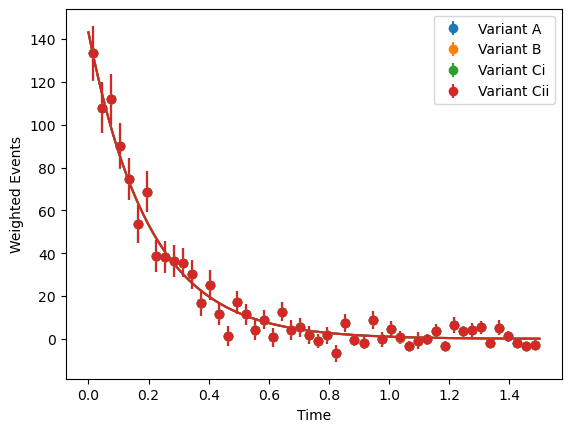

In [11]:
# signal pdf in t-domain
def t_signal_pdf(x, slope):
    return t_density(x, 1, 0, slope, 0, 1)

### Plot the weighted decay distributions and the fit result
sws_variant_a = sweight_variant_a(toy[0])
sws_variant_b = sweight_variant_b(toy[0])
sws_variant_ci = sweight_variant_ci(toy[0])
sws_variant_cii = sweight_variant_cii(toy[0])

bins = 50
t = np.linspace(*trange, 400)

for i, (w, method, slope) in enumerate(
    zip(
        (sws_variant_a, sws_variant_b, sws_variant_ci, sws_variant_cii),
        ("Variant A", "Variant B", "Variant Ci", "Variant Cii"),
        fitted_slopes,
    )
):
    color = f"C{i}"
    plot_binned(
        toy[1],
        bins=bins,
        range=trange,
        weights=w,
        label=method,
        color=color,
    )
    tnorm = np.sum(w) * (trange[1] - trange[0]) / bins
    plt.plot(t, tnorm * t_signal_pdf(t, slope), color=color)
	

plt.legend()
plt.xlabel("Time")
plt.ylabel("Weighted Events");

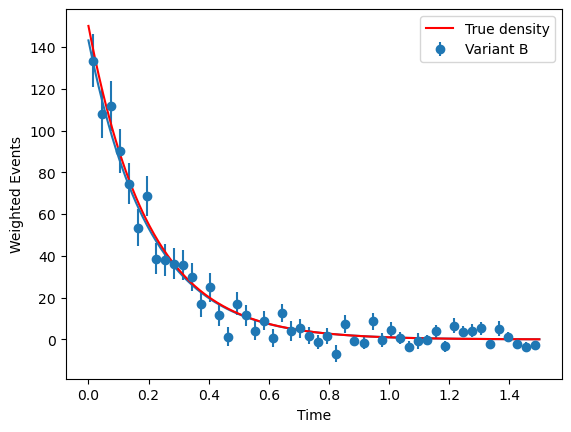

In [12]:
# signal pdf in t-domain
def t_signal_pdf(x, slope):
    return t_density(x, 1, 0, slope, 0, 1)

### Plot the weighted decay distributions and the fit result
sws_variant_a = sweight_variant_a(toy[0])
sws_variant_b = sweight_variant_b(toy[0])
sws_variant_ci = sweight_variant_ci(toy[0])
sws_variant_cii = sweight_variant_cii(toy[0])

bins = 50
t = np.linspace(*trange, 400)

for i, (w, method, slope) in enumerate(
    zip([(sws_variant_b)], [("Variant B")], fitted_slopes)
):
    color = f"C{i}"
    plot_binned(
        toy[1],
        bins=bins,
        range=trange,
        weights=w,
        label=method,
        color=color,
    )
    tnorm = np.sum(w) * (trange[1] - trange[0]) / bins
    plt.plot(t, tnorm * t_signal_pdf(t, slope), color=color)

plt.plot(t, 1000 * (trange[1] - trange[0]) / bins * t_signal_pdf(t, 0.2), color="red", label="True density")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Weighted Events");

### Can we really factorise the density?

So far we have considered only where the pdf is a mixture of two components that each factorise in both the discriminant and control variables, but is this really a correct assumption to make? To do this it's recomended to perform a USP test of independence -> example [4], though the majority of the time you can kind of eye ball it.

[4]: https://sweights.github.io/sweights/notebooks/factorization_test.html "Factorization test example"

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
import numpy as np
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import Minuit

from sweights.testing import make_classic_toy
from sweights.util import plot_binned, make_bernstein_pdf
from sweights.independence import kendall_tau
from sweights.experimental import Cows

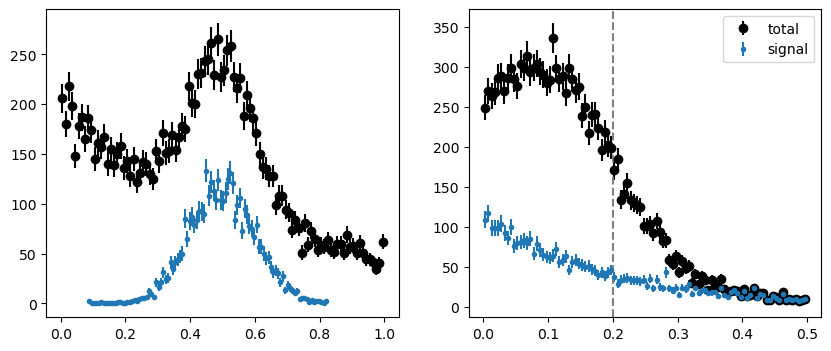

In [14]:
range = (0.0, 1.0)
trange = (0.0, 0.5)
tsplit = 0.2

toy = make_classic_toy(
    1, s=4000, b=10000, mrange=mrange, trange=trange, mb_mu=lambda t: 0.1 + 10 * (t / 1.5)
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plot_binned(toy[0], bins=100, color="k", label="total")
plot_binned(toy[0][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.sca(ax[1])
plot_binned(toy[1], bins=100, color="k", label="total")
plot_binned(toy[1][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.axvline(tsplit, ls="--", color="0.5")
plt.legend();

Can see when I plot in intervals of t:

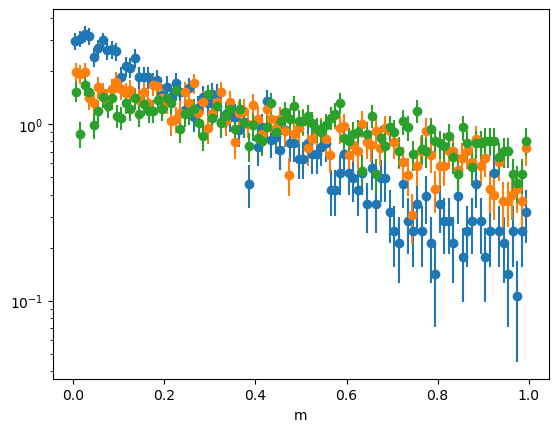

In [15]:
tsplit = np.quantile(toy[1], (0, 0.3, 0.6, 1.0))
for ta, tb in zip(tsplit[:-1], tsplit[1:]):
    m = toy[0][~toy[2]]
    t = toy[1][~toy[2]]
    ma = (ta <= t) & (t < tb)
    plot_binned(m[ma], density=True)
plt.semilogy()
plt.xlabel("m");

### Custom orthogonal weight functions (COWs)

Lets now generalise to an abitrary number of factorising components, and also allow for a non-factorising function of frequency weights, $\epsilon(m,t)$, which is normally referred to as the efficiency. One could seperate signal and background first, but we could have the situation where the signal and background are non-factorising because of the effect of the efficiency function.

Nevertheless we define a pdf for the observed data:

$$

\rho(m, t)=\frac{1}{D} \epsilon(m, t) f(m, t) \quad \text { with } \quad D=\int \mathrm{d} m \mathrm{~d} t \epsilon(m, t) f(m, t) .

$$

where D is a normalisation constant.

The true density, $f(m, t)$ of the events we expand into n factorising components (instead of the two signal and background we had before):

$$

f(m, t)=\sum_{k=0}^n z_k g_k(m) h_k(t) \quad \text { with } \quad \sum_{k=0}^n z_k=1 .

$$

Now this is the logic, we define that the first s terms pertain to the signal density while the others describe the background, i.e.

$$
f(m, t)=\underbrace{\sum_{k=0}^{s-1} z_k g_k(m) h_k(t)}_{\text {signal }}+\underbrace{\sum_{k=s}^n z_k g_k(m) h_k(t)}_{\text {background }} .
$$

So although each source is created by sums of factorising terms, the partial sum itself in general produces a non-factorising function.

Any single function $h_k(t)$ in $f(m, t)$ can be isolated by a weight function

$$
w_k(m)=\sum_{\ell=0}^n \frac{A_{k \ell} g_{\ell}(m)}{I(m)} \text { with } A=W^{-1} \text { and } W_{k \ell}=\int \mathrm{d} m \frac{g_k(m) g_{\ell}(m)}{I(m)} .
$$

Now the denominator is left more general as function $I(m)$, which is an arbitrary non-zero function in the considered range of m and is dubbed the variance function.

And if I want the weights for the signal (or background) in total, all I have to do is sum all the weight from the sources that pertain to the signal, yes, COWs are additive:

$$

w_{s}(t) = \sum_{k=0}^{s-1} w_{k}(t)

$$

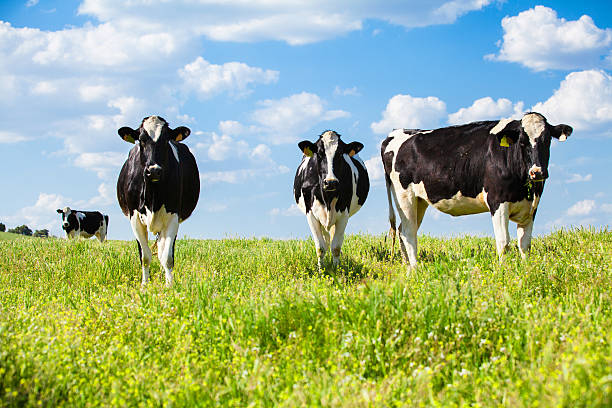

We also can derive the same orthonormal conditions from before:

$$

\int \mathrm{d} m w_k(m) g_{\ell}(m)=\delta_{k \ell}.

$$

We must also account of the extra bits:

$$

w_k^{\prime}(m, t)=D \frac{w_k(m)}{\epsilon(m, t)}

$$

and further we can see that the expectation value of the COW in an infinitesimal bin, dt, in the control variable is:

$$

\frac{\mathrm{d}}{\mathrm{~d} t} \mathrm{E}\left[D \frac{w_k(m)}{\epsilon(m, t)}\right]=z_k h_k(t),

$$

so it is an asymptotically unbiased estimate of the efficiency corrected density, $h_k(t)$, for any choice $I(m)$.

Analogous to the first section, the estimates for COWs corresponding to variant A and B for sWeights are:

$$

\begin{aligned}
\widehat{W}_{k \ell}^A & =\int \mathrm{d} m \frac{\hat{g}_k(m) \hat{g}_{\ell}(m)}{\hat{I}(m)} \\
\widehat{W}_{k \ell}^B & =\frac{1}{N} \sum_i \frac{\hat{g}_k\left(m_i\right) \hat{g}_{\ell}\left(m_i\right)}{\hat{\rho}_m\left(m_i\right) \hat{I}\left(m_i\right)},
\end{aligned}

$$

where $\rho_m(m)=\int \mathrm{d} t \rho(m, t)$.


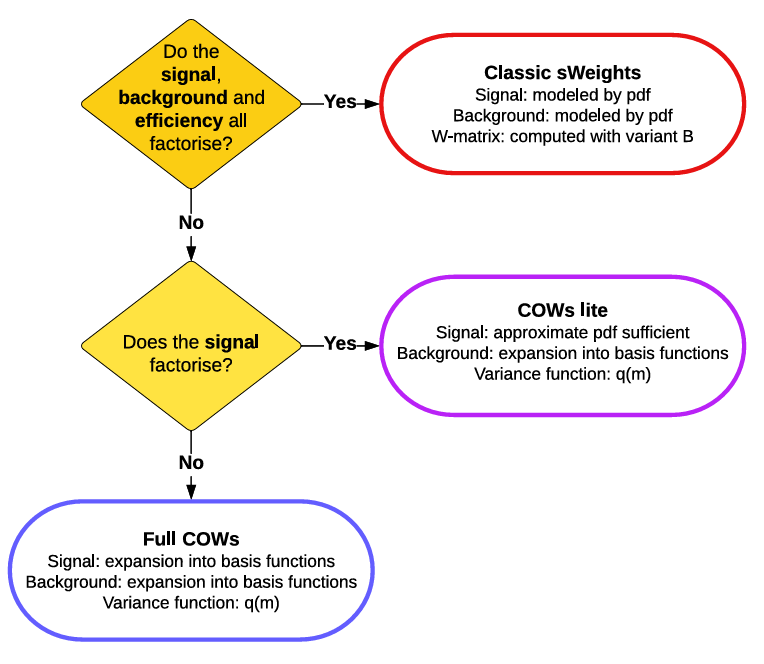

For our example above we will say it fits into this COWs lite category, as the background is non-factorising.

In [16]:
bern = make_bernstein_pdf(2, *mrange)

# m-density for fitting and plotting (not normalized)
def m_density(x, s, b1, b2, b3, mu, sigma):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))
    return s / snorm * ds.pdf(x) + b1 * bern[0](x) + b2 * bern[1](x) + b3 * bern[2](x)


# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(x, s, b1, b2, b3, mu, sigma):
    return (s + b1 + b2 + b3, m_density(x, s, b1, b2, b3, mu, sigma))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=10000,
    mu=0.5,
    sigma=0.1,
    b1=10000,
    b2=10000,
    b3=10000
)
mi.limits["s", "b1", "b2", "b3"] = (0, None)
mi.limits["mu"] = mrange
mi.limits["sigma"] = (0, None)

mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.413e+05                 │              Nfcn = 249              │
│ EDM = 1.16e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  3.96e3   │  0.22e3   │            │            │    0    │         │       │
│ 1 │ b1    │  6.33e3   │  0.14e3   │            │            │    0    │         │       │
│ 2 │ b2    │   2.0e3   │   0.4e3   │            │            │    0    │         │       │
│ 3 │ b3    │  1.63e3   │  0.10e3   │            │            │    0    │         │       │
│ 4 │ mu    │  0.5006   │  0.0029   │            │            │    0    │    1    │       │
│ 5 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────┐
│       │           s          b1          b2          b3          mu       sigma │
├───────┼─────────────────────────────────────────────────────────────────────────┤
│     s │    4.78e+04     0.011e6     -0.07e6        12e3   -1.570e-3  678.136e-3 │
│    b1 │     0.011e6     1.9e+04    -0.030e6         6e3   88.518e-3  146.243e-3 │
│    b2 │     -0.07e6    -0.030e6    1.26e+05       -27e3  -73.293e-3 -988.143e-3 │
│    b3 │        12e3         6e3       -27e3    9.63e+03  -13.654e-3  163.814e-3 │
│    mu │   -1.570e-3   88.518e-3  -73.293e-3  -13.654e-3    8.24e-06       -0e-6 │
│ sigma │  678.136e-3  146.243e-3 -988.143e-3  163.814e-3       -0e-6    1.53e-05 │
└───────┴─────────────────────────────────────────────────────────────────────────┘

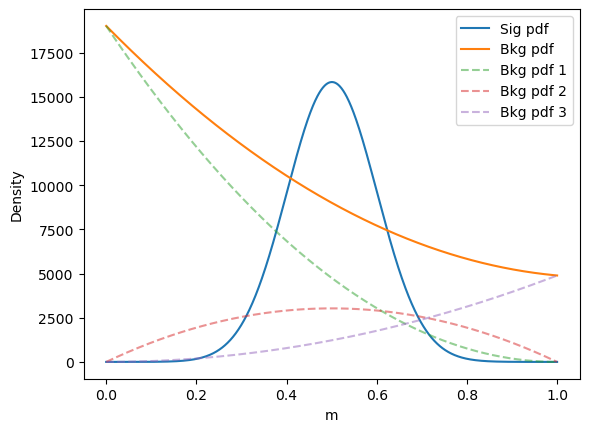

In [17]:
def spdf(m):
    return m_density(m, 1, 0, 0, 0, *mi.values[-2:])


def bpdf(m):
    b1, b2, b3 = mi.values[1:4]
    bt = b1 + b2 + b3
    return m_density(m, 0, b1/bt, b2/bt, b3/bt, *mi.values[-2:])

def bpdf1(m):
	b1, b2, b3 = mi.values[1:4]
	return m_density(m, 0, 1, 0, 0, *mi.values[-2:])

def bpdf2(m):
	b1, b2, b3 = mi.values[1:4]
	return m_density(m, 0, 0, 1, 0, *mi.values[-2:])

def bpdf3(m):
	b1, b2, b3 = mi.values[1:4]
	return m_density(m, 0, 0, 0, 1, *mi.values[-2:])

mp = np.linspace(*mrange, 1000)
plt.plot(mp, mi.values['s'] * spdf(mp), label="Sig pdf");

b1, b2, b3 = mi.values[1:4]
plt.plot(mp, (b1 + b2 + b3) * bpdf(mp), label="Bkg pdf");
plt.plot(mp, b1 * bpdf1(mp), "--", label="Bkg pdf 1", alpha=0.5);
plt.plot(mp, b2 * bpdf2(mp), "--", label="Bkg pdf 2", alpha=0.5);
plt.plot(mp, b3 * bpdf3(mp), "--", label="Bkg pdf 3", alpha=0.5);
plt.xlabel("m");
plt.ylabel("Density");
plt.legend();

We construct classic sWeights, COWs with a single background component, and finally COWs with multiple background components. For the last case, we use the Bernstein basis polynomials as background components. As explained, using multiple background components increases the variance of the weights and reduces the statistical precision of any derived results, but has the potential to avoid the bias from non-factorization.

In [18]:
# compute classic sWeights
sweight = Cows(toy[0], spdf, bpdf, range=mrange)
# compute COWs with integration method, flat norm, and same two components
cow = Cows(None, spdf, bpdf, range=mrange)
# compute classic sWeights with several background components
# nf stands for non-factorizing
sweight_nf = Cows(toy[0], spdf, bern, range=mrange)

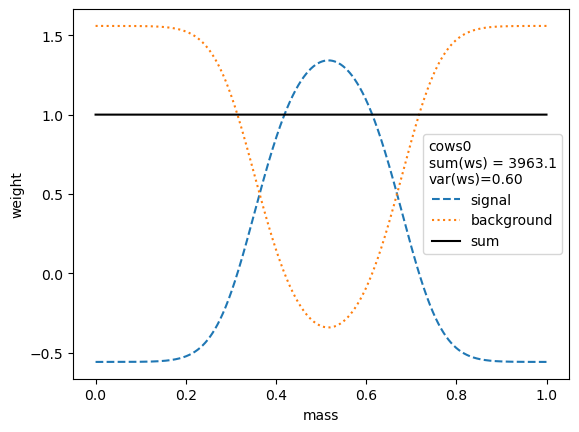

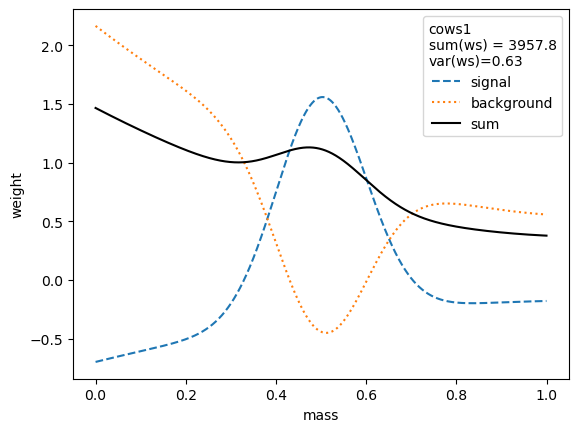

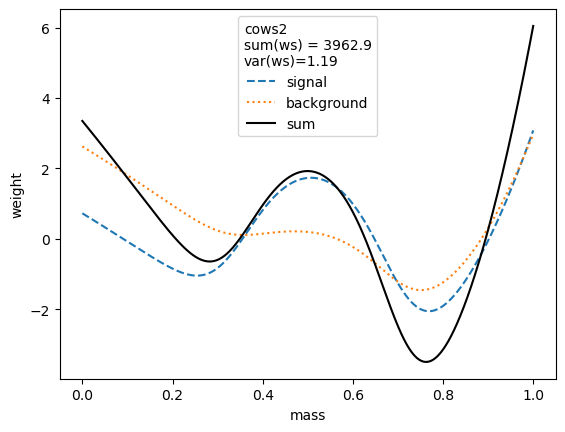

In [22]:
    
for i, weighter in enumerate([sweight, cow, sweight_nf]):
    # x = np.linspace(*mrange, 400)
    x = np.sort(toy[0])
    swp = weighter[0](x)
    bwp = weighter[1](x)

    plt.figure()
    plt.plot(x, swp, "C0--", label="signal")
    plt.plot(x, bwp, "C1:", label="background")
    plt.plot(x, swp + bwp, "k-", label="sum")
    plt.xlabel("mass")
    plt.ylabel("weight")
    plt.legend(title=(
        f"cows{i}\n"
        f"sum(ws) = {np.nansum(swp):.1f}\n"
        f"var(ws)={np.nanvar(swp):.2f}"))



Only the COW (sWeights in this case) with multiple background components recover the exponential distribution of the projected signal in the t-variable. The other projections are not exponential.

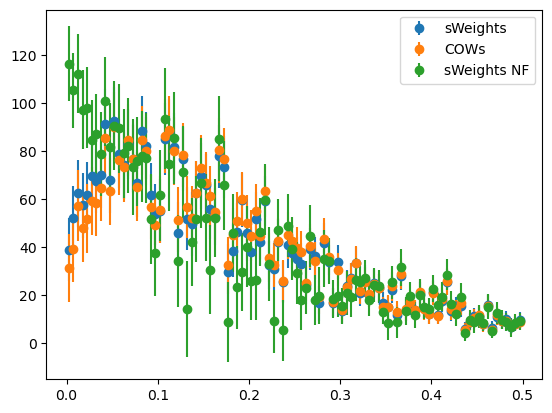

In [38]:
for method, weighter in (
    ("sWeights", sweight),
    ("COWs", cow),
    ("sWeights NF", sweight_nf),
):
    plot_binned(toy[1], weights=weighter(toy[0]), label=method)
# plt.semilogy()
plt.legend();

Further perfroming an extended binned fit, only this method reproduces the correct slope:

In [37]:
from iminuit.cost import ExtendedBinnedNLL

for method, weighter in (("sWeights", sweight), ("COWs", cow), ("sWeights NF", sweight_nf)):
    # get signal weights
    w = weighter(toy[0])

    # do the minimisation

    val, xe = np.histogram(toy[1], weights=w)
    var = np.histogram(toy[1], bins=xe, weights=w**2)[0]

    data = np.transpose((val, var))
    cost = ExtendedBinnedNLL(data, xe, lambda x, n, slope: n * expon.cdf(x, 0, slope))
    tmi = Minuit(cost, n=10000, slope=0.1)
    tmi.limits["n", "slope"] = (0.01, None)
    tmi.migrad()
    tmi.hesse()
    val = tmi.values["slope"]
    err = tmi.errors["slope"]
    print(f"{method:10}: slope = {val:.2f} +/- {err:.2f} "
          f"(chi2/ndof = {tmi.fmin.reduced_chi2:.1f})")

sWeights  : slope = 0.23 +/- 0.01 (chi2/ndof = 5.9)
COWs      : slope = 0.23 +/- 0.01 (chi2/ndof = 8.8)
sWeights NF: slope = 0.20 +/- 0.01 (chi2/ndof = 0.4)


The paper "Custom Orthogonal Weight functions (COWs) for event classification" and the sweight package can be found on https://sweights.github.io/sweights/index.html , There is also some nice examples on the paper.